In [1]:
import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import random as rd
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from MogrifierLSTM import MogrifierLSTMCell
from utils.dataset import NCDFDatasets
from utils.evaluator import Evaluator
import adamod


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

In [4]:
batch_size = 20
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.2
hidden_size = 2500
prediction_window=5
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}

In [5]:
import xarray as xr
data_path = '../../data/dataset-chirps-1981-2019-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 50, lon: 50, sample: 13960, time: 5)
Coordinates:
  * lat      (lat) int64 -39 -38 -37 -36 -35 -34 -33 -32 ... 3 4 5 6 7 8 9 10
  * lon      (lon) int64 -84 -83 -82 -81 -80 -79 -78 ... -40 -39 -38 -37 -36 -35
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have preciptation values and are separable in...


In [6]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = 0.2, test_split = 0.2)
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [7]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)

-----Train-----
X :  torch.Size([8376, 1, 5, 50, 50])
Y :  torch.Size([8376, 1, 5, 50, 50])
-----Val-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 5, 50, 50])
-----Test-----
X :  torch.Size([2792, 1, 5, 50, 50])
Y :  torch.Size([2792, 1, 5, 50, 50])


In [8]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [9]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

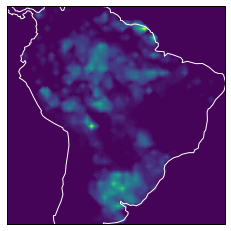

In [10]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
#sample, ch, time, lat, lon
sst = train_data.y[0, 0, 0, :, :]
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(lons, lats, sst, 60,
             transform=ccrs.PlateCarree())
ax.coastlines(color='white')

plt.show()

In [11]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [12]:
class SELayer(torch.nn.Module):
    def __init__(self, out_channels, ratio):
        super(SELayer, self).__init__()
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)
        out_channels_reduced = out_channels // ratio
        if (out_channels_reduced == 0):
            out_channels_reduced = 1
        self.fc1 = torch.nn.Linear(out_channels, out_channels_reduced, bias=True)
        self.fc2 = torch.nn.Linear(out_channels_reduced, out_channels, bias=True)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        batch_size, num_channels, _, _ = x.size()
        # Average along each channel
        squeeze_tensor = self.avg_pool(x)

        # channel excitation
        fc_out_1 = self.relu(self.fc1(squeeze_tensor.view(batch_size, num_channels)))
        fc_out_2 = self.sigmoid(self.fc2(fc_out_1))

        output_tensor = torch.mul(x, fc_out_2.view(batch_size, num_channels, 1, 1))

        return output_tensor

In [13]:
class CustomConv2d(torch.nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
        self.padding = [kernel_size // 2, kernel_size // 2]
        if (weight is not None):
            self.weight = Parameter(weight.permute(1,0,2,3))
        
    def forward(self,input):
        return F.conv2d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [14]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, input_size, hidden_size
                 ,device):
        super(EncoderCNN, self).__init__()
        self.device = device
        self.conv_layers = torch.nn.ModuleList()
        self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        self.se_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        ratio = 2
        
        for i in range(layer_size):
            if (i == layer_size-1):
                out_channels = 1
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size))
            self.mish_layers.append(Mish())
            self.bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            self.se_layers.append(SELayer(out_channels, ratio))
            self.dropout_layers.append(torch.nn.Dropout(dropout_rate))
            in_channels = out_channels
        self.recurrent = torch.nn.LSTMCell(input_size, hidden_size);
            
            
            
    def forward(self, x, states, dimens):
        batch, channel, time, lat, lon = dimens
        x = x.view(batch*time, channel, lat, lon)
        for conv, bn, mish, se, dropout in zip(self.conv_layers, self.bn_layers, self.mish_layers, self.se_layers,
                                           self.dropout_layers):
            x = conv(x)
            x = bn(x)
            x = mish(x)
            x = se(x)
            x = dropout(x)
        x = x.view(batch, time, -1)
        h = states[0]
        c = states[1]
        for i in range(time):
            h,c = self.recurrent(x[:,i,:],(h,c))
        return (h, c)

In [15]:
class DecoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, encoder_weights, input_size
                 ,device):
        super(DecoderCNN, self).__init__()
        self.device = device
        self.conv_layers = torch.nn.ModuleList()
        self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.dropout_layers = torch.nn.ModuleList()
        self.se_layers = torch.nn.ModuleList()
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        ratio = 2
        self.recurrent = torch.nn.LSTMCell(input_size, hidden_size);
        
        for i in range(layer_size):
            if (i == layer_size-1):
                out_channels = 1
            self.conv_layers.append(CustomConv2d(in_channels = in_channels, out_channels = out_channels,
                                                kernel_size = kernel_size, weight=encoder_weights[i]))
            self.mish_layers.append(Mish())
            self.bn_layers.append(torch.nn.BatchNorm2d(out_channels))
            self.se_layers.append(SELayer(out_channels, ratio))
            self.dropout_layers.append(torch.nn.Dropout(dropout_rate))
            in_channels = out_channels
            
            
    def forward(self, states, dimens, window):
        batch, channel, time, lat, lon = dimens
        outputs = torch.zeros(batch, window, lat*lon, device=self.device)
        h = states[0]
        c = states[1]
        for i in range(window):
            h,c = self.recurrent(h,(h,c))
            outputs[:,i,:] = h
        x = outputs.contiguous().view(batch*window, channel, lat, lon)
        for conv, bn, mish, se, dropout in zip(self.conv_layers, self.bn_layers, self.mish_layers, self.se_layers,
                                               self.dropout_layers):
            x = conv(x)
            x = bn(x)
            x = mish(x)
            x = se(x)
            x = dropout(x)
        return x.view(batch, window, channel, lat, lon)

In [16]:
class STModel(torch.nn.Module):
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, out_channels, in_channels, input_width, input_height, hidden_size,
                prediction_window, device):
        super(STModel, self).__init__()
        self.device = device
        self.prediction_window = prediction_window
        self.encoder = EncoderCNN(layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, input_size=input_width*input_height,
                                 hidden_size = hidden_size, device=device)
        encoder_weights = [layer.weight for layer in self.encoder.conv_layers][::-1]
        self.decoder = DecoderCNN(layer_size = decoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, encoder_weights = encoder_weights, 
                                 input_size=input_width*input_height, device=device)
        
        
    def forward(self, x, states):
        dimens = x.size()
        (h_t, c_t) = self.encoder(x, states, dimens)
        x = self.decoder((h_t,c_t), dimens, self.prediction_window)
        return x
        

In [17]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss


In [18]:
class Evaluator:
    def __init__(self, model, loss, data_loader, device):
        self.model = model
        self.loss = loss
        self.data_loader = data_loader
        self.device = device
        
    def evaluate(self):
        with torch.no_grad():
            eval_loss = 0.0
            self.model.eval()
            for i, (x, y) in enumerate(self.data_loader):
                x,y = x.to(self.device), y.to(self.device)
                states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
                output = self.model(x, states)
                loss = self.loss(output, y)
                eval_loss += loss.detach().item()
            avg_loss = eval_loss/len(self.data_loader)
        return avg_loss

class TrainingStop:
    def __init__(self, threshold):
        self.min_loss = sys.float_info.max
        self.count = 0
        self.threshold = threshold
        
    def check_stop_condition(self, curr_loss):
        if (curr_loss < self.min_loss):
            self.min_loss = curr_loss
            self.count = 0
            return False
        else:
            self.count += 1
            if (self.count >= self.threshold):
                return True
            return False

In [19]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)

In [20]:
model = STModel(encoder_layer_size = param['encoder_layer_size'], decoder_layer_size = param['decoder_layer_size']
                ,kernel_size = param['kernel_size'], out_channels = param['filter_size'],
                in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3], 
                input_height = train_data.x.shape[4], hidden_size = hidden_size, 
                prediction_window = prediction_window, device=device).to(device)
criterion = RMSELoss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)
model

STModel(
  (encoder): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (1): CustomConv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
      (2): CustomConv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2], bias=False)
    )
    (mish_layers): ModuleList(
      (0): Mish()
      (1): Mish()
      (2): Mish()
    )
    (bn_layers): ModuleList(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.2, inplace=False)
      (1): Dropout(p=0.2, inplace=False)
      (2): Dropout(p=0.2, inplace=False)
    )
    (se_layers): ModuleList(
      (0): SELayer(
        (avg_pool): AdaptiveAvgPool2

In [21]:
train_losses, val_losses = [], []
evaluator = Evaluator(model, criterion, val_loader, device)
training_stopper = TrainingStop(3)
for epoch in range(1,100):
    train_loss = model.train()
    epoch_train_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x,y = x.to(device), y.to(device)
        states = init_hidden(x.size()[0], x.size()[3]*x.size()[4])
        optimizer.zero_grad()
        output = model(x, states)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.detach().item()
    print(epoch_train_loss)
    avg_epoch_loss = epoch_train_loss/len(train_loader)
    train_losses.append(avg_epoch_loss)
    print('Train - Epoch %d, Batch: %d, Epoch Loss: %f' % (epoch, i, avg_epoch_loss))
    
    avg_loss = evaluator.evaluate()
    val_losses.append(avg_loss)
    print('Val Avg. Loss: %f' % (avg_loss))
    if (torch.cuda.is_available()):
                torch.cuda.empty_cache()
    if (training_stopper.check_stop_condition(avg_loss)):
        break

3112.942864894867
Train - Epoch 1, Batch: 418, Epoch Loss: 7.429458
Val Avg. Loss: 7.443929
3043.8473777770996
Train - Epoch 2, Batch: 418, Epoch Loss: 7.264552
Val Avg. Loss: 7.132409
2905.3901495933533
Train - Epoch 3, Batch: 418, Epoch Loss: 6.934105
Val Avg. Loss: 6.887627
2765.856708049774
Train - Epoch 4, Batch: 418, Epoch Loss: 6.601090
Val Avg. Loss: 6.640914
2667.050088405609
Train - Epoch 5, Batch: 418, Epoch Loss: 6.365275
Val Avg. Loss: 6.506451
2607.983069896698
Train - Epoch 6, Batch: 418, Epoch Loss: 6.224303
Val Avg. Loss: 6.428207
2576.5214371681213
Train - Epoch 7, Batch: 418, Epoch Loss: 6.149216
Val Avg. Loss: 6.344833
2559.25430727005
Train - Epoch 8, Batch: 418, Epoch Loss: 6.108006
Val Avg. Loss: 6.336654
2548.6964383125305
Train - Epoch 9, Batch: 418, Epoch Loss: 6.082808
Val Avg. Loss: 6.353600
2541.5892605781555
Train - Epoch 10, Batch: 418, Epoch Loss: 6.065845
Val Avg. Loss: 6.340833
2536.2118439674377
Train - Epoch 11, Batch: 418, Epoch Loss: 6.053012
Val A

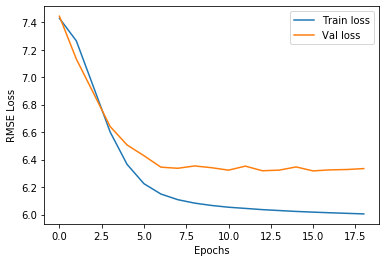

In [22]:
epochs = np.arange(1,len(val_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [23]:
evaluator = Evaluator(model, criterion, test_loader, device)
test_loss = evaluator.evaluate()
loss_type = type(criterion).__name__
print(f'STTSModel {loss_type}: {test_loss:.4f}')

STTSModel RMSELoss: 6.3225
